# Tree Segmentation Example
This is a simple example of what the PyCrown package can do: from pre-calculated rasters (CHM, DSM and DTM) and a height-normalized 3D LiDAR point cloud, individual trees can be segmented.
Outputs are shapefiles of tree top locations, crown shapes as well as a .LAS-file containing classified trees.

## Start with importing the modules

In [1]:
import sys
from datetime import datetime
from pycrown import PyCrown

## Set input files
Specify the file locations for the CHM, DSM, DTM and the LiDAR point cloud.
The latter is only needed if the point cloud should be classified into individual trees.

In [2]:
F_CHM = 'data/CHM.tif'
F_DTM = 'data/DTM.tif'
F_DSM = 'data/DSM.tif'
F_LAS = 'data/POINTS.las'

## Initialize an instance of PyCrown

In [3]:
PC = PyCrown(F_CHM, F_DTM, F_DSM, F_LAS, outpath='result')

## Clip all input data to new bounding box.

In [4]:
PC.clip_data_to_bbox((1802150, 1802408, 5467305, 5467480))

## Smooth CHM
A 5x5m block median filter is used (set circular=True to enable a disc-shaped window).

In [5]:
PC.filter_chm(5, ws_in_pixels=True, circular=False)

## Tree Detection with local maximum filter

In [6]:
PC.tree_detection(PC.chm, ws=5, hmin=16.)

## Clip trees to bounding box 
(no trees on image edge)
original extent: 1802140, 1802418, 5467295, 5467490    

In [7]:
PC.clip_trees_to_bbox(bbox=(1802160, 1802400, 5467315, 5467470))

## Crown Delineation

In [8]:
PC.crown_delineation(algorithm='dalponteCIRC_numba', th_tree=15.,
                     th_seed=0.7, th_crown=0.55, max_crown=10.)

Tree crowns delineation: 0.001s


In [19]:
PC.tree_markers

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32)

In [24]:
PC._tree_colrow('top',1)

array([[138, 219, 238, 116,  29,  92,  64, 227, 129,  18,  81, 106,  50,
        169, 242,  14,  93,  71, 186, 140, 216,  30,  45, 156,  84, 116,
        194,  36, 238, 172, 212,  90,  53, 116, 191, 229, 243, 179, 199,
         18, 219,  76, 167, 159,  31,  62, 146,  46, 110, 242, 176,  33,
        219,  15, 187,  48,  75, 125, 117,  82,  17, 164,  24, 176,  74,
        104, 239, 230,  23, 144, 207, 194,  84, 176, 213,  73,  45, 106,
        169, 153, 225, 203,  61,  80, 155,  31, 246,  49,  66, 110, 118,
        246,  79,  10,  98, 209,  35, 114,  71, 143, 156, 132, 195, 177,
        212,  84, 114, 165, 236,  38, 127, 224, 218,  20,  66, 186, 104,
        117, 144,  13, 124,  23,  35, 163, 200, 211,  93, 191],
       [ 10,  10,  11,  12,  16,  16,  16,  17,  18,  19,  21,  21,  23,
         22,  24,  25,  26,  27,  26,  29,  31,  32,  32,  32,  34,  33,
         34,  38,  37,  40,  42,  46,  46,  46,  46,  48,  48,  48,  49,
         50,  49,  50,  53,  54,  55,  56,  58,  58,  59,  5

In [11]:
import matplotlib.pyplot as plt

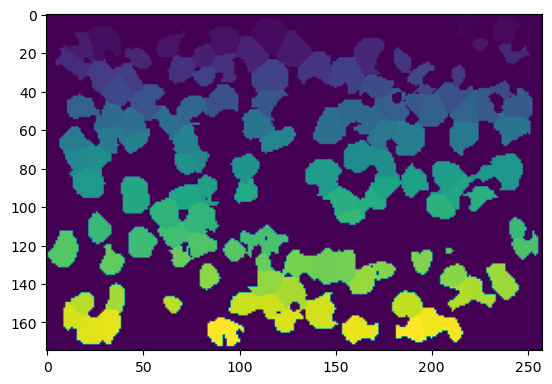

In [12]:
plt.imshow(PC.crowns)

## (Optional) Correct tree tops on steep terrain

In [9]:
PC.correct_tree_tops()

Number of trees: 128
Tree tops corrected: 9
Tree tops corrected: 7.03125%
DSM correction: 5
COM correction: 4


## Calculate tree height and elevation

In [10]:
PC.get_tree_height_elevation(loc='top')
PC.get_tree_height_elevation(loc='top_cor')

## Screen small trees

In [11]:
PC.screen_small_trees(hmin=20., loc='top')

## Convert raster crowns to polygons

In [12]:
PC.crowns_to_polys_raster()
PC.crowns_to_polys_smooth(store_las=True)

Converting LAS point cloud to shapely points
Converting raster crowns to shapely polygons
Attach LiDAR points to corresponding crowns
Create convex hull around first return points
Classifying point cloud


## Check that all geometries are valid

In [13]:
PC.quality_control()

## Print out number of trees

In [14]:
print(f"Number of trees detected: {len(PC.trees)}")

Number of trees detected: 115


## Export results

In [15]:
PC.export_raster(PC.chm, PC.outpath / 'chm.tif', 'CHM')
PC.export_tree_locations(loc='top')
PC.export_tree_locations(loc='top_cor')
PC.export_tree_crowns(crowntype='crown_poly_raster')
PC.export_tree_crowns(crowntype='crown_poly_smooth')